In [1]:
!pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 KB 13.5 MB/s eta 0:00:00


In [2]:
import gymnasium as gym2
from collections import deque
import numpy as np
import random

In [3]:
"""
desc=["SFFF", "FHFH", "FFFH", "HFFG"].

A random generated map can be specified by calling the function `generate_random_map`. For example,


from gym.envs.toy_text.frozen_lake import generate_random_map

gym.make('FrozenLake-v1', desc=generate_random_map(size=8))
"""

'\ndesc=["SFFF", "FHFH", "FFFH", "HFFG"].\n\nA random generated map can be specified by calling the function `generate_random_map`. For example,\n\n\nfrom gym.envs.toy_text.frozen_lake import generate_random_map\n\ngym.make(\'FrozenLake-v1\', desc=generate_random_map(size=8))\n'

In [4]:
env = gym2.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False,  render_mode="rgb_array")

In [5]:
env.observation_space.n, env.action_space.n

(16, 4)

In [6]:
env.spec.max_episode_steps = 1000
env.spec.max_episode_steps

1000

In [7]:
s, info = env.reset()

In [8]:
v = env.render()
v.shape

(256, 256, 3)

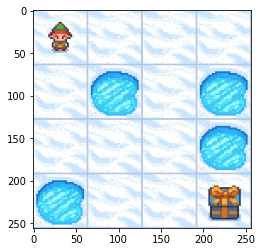

In [9]:
import matplotlib.pyplot as plt
plt.imshow(v)
plt.show()

# Test with random actions

Episode 0
Step 0


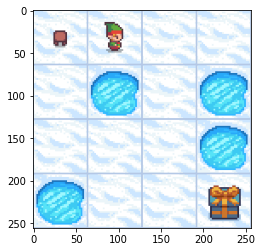

Step 1


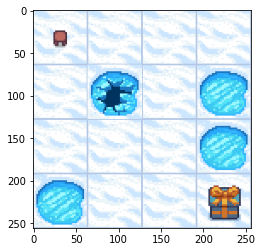

State 5, action 1, next_state 5, reward 0.0, done True, truncate False, info {'prob': 1.0}


<Figure size 432x288 with 0 Axes>

In [10]:
fig, ax = plt.subplots()
plt.ion()
for i in range(1):
  s, info = env.reset()
  print(f"Episode {i}")
  for j in range(5):
    print(f"Step {j}")
    a = env.action_space.sample()
    s_n, r, d, t, info = env.step(a)    
    s = s_n

    v = env.render()
    plt.imshow(v)
    plt.draw()
    plt.pause(0.01)
    plt.clf()
    if d or t:
      print(f"State {s}, action {a}, next_state {s_n}, reward {r}, " \
            f"done {d}, truncate {t}, info {info}")
      break

# Solution by human inspection

◀️ LEFT = 0

🔽 DOWN = 1

▶️ RIGHT = 2

🔼 UP = 3


In [11]:
action_map = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}

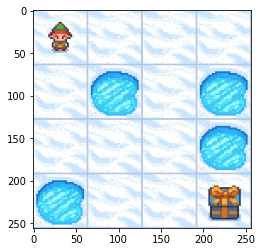


Episode 0. Step 0, R_sum 0.0


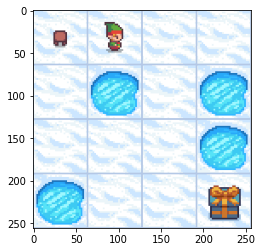


Episode 0. Step 1, R_sum 0.0


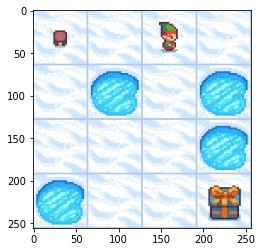


Episode 0. Step 2, R_sum 0.0


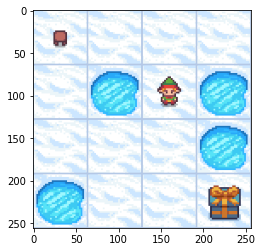


Episode 0. Step 3, R_sum 0.0


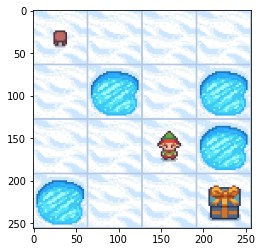


Episode 0. Step 4, R_sum 0.0


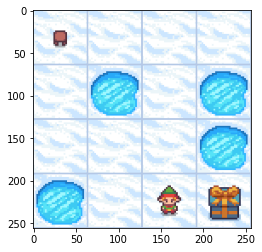


Episode 0. Step 5, R_sum 0.0


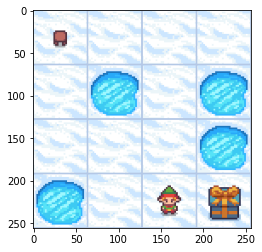


Episode 0. Step 6, R_sum 1.0


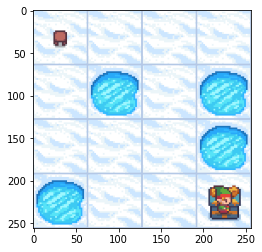


End of BEST ACTION EPISODE




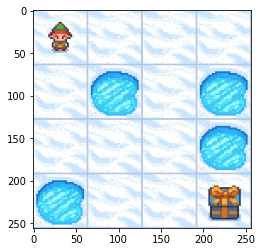


Episode 1. Step 0, R_sum 0.0


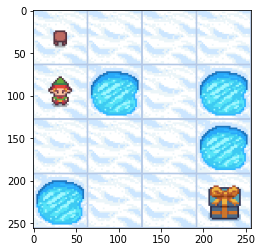


Episode 1. Step 1, R_sum 0.0


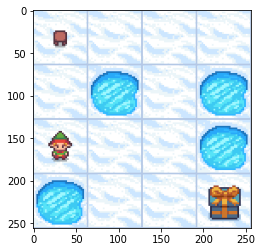


Episode 1. Step 2, R_sum 0.0


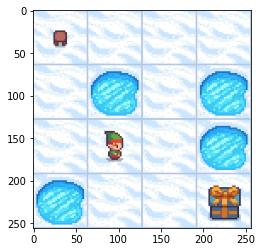


Episode 1. Step 3, R_sum 0.0


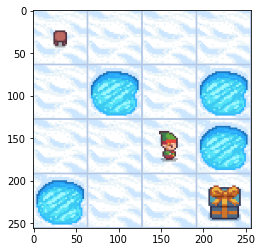


Episode 1. Step 4, R_sum 0.0


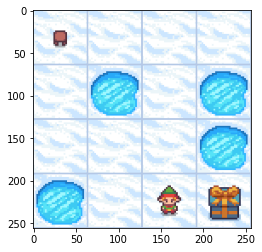


Episode 1. Step 5, R_sum 1.0


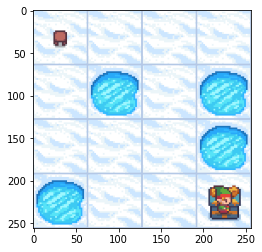


End of BEST ACTION EPISODE




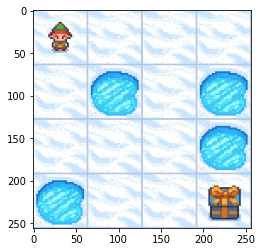


Episode 2. Step 0, R_sum 0.0


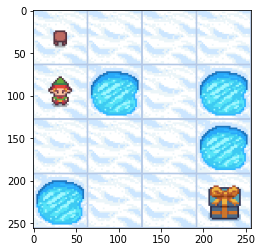


Episode 2. Step 1, R_sum 0.0


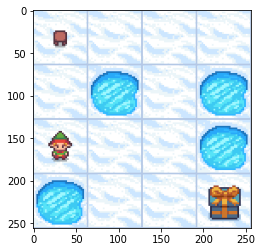


Episode 2. Step 2, R_sum 0.0


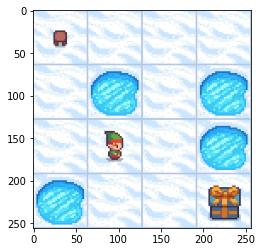


Episode 2. Step 3, R_sum 0.0


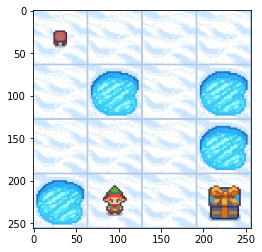


Episode 2. Step 4, R_sum 0.0


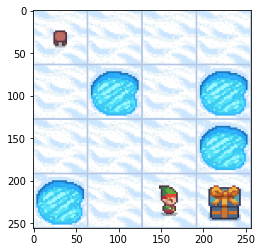


Episode 2. Step 5, R_sum 1.0


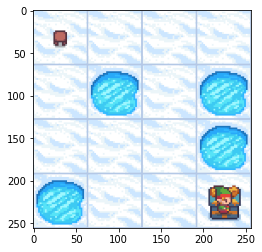


End of BEST ACTION EPISODE




In [16]:

best_action_sequences = [
    [2, 2, 1, 1, 1, 1, 2],
    [1, 1, 2, 2, 1, 2],
    [1, 1, 2, 1, 2, 2]
]
for j, best_actions in enumerate(best_action_sequences):
  R = 0
  s, info = env.reset()
  for i, a in enumerate(best_actions):
    plt.imshow(env.render())
    plt.draw()
    plt.pause(1)
    s_n, r, d, t, info = env.step(a)
    s = s_n
    R += r
    print(f"\nEpisode {j}. Step {i}, R_sum {R}")
  plt.imshow(env.render())
  plt.draw()
  plt.pause(1)
  print("\nEnd of BEST ACTION EPISODE\n\n")

# Define a Q-table model as a numpy matrix instantiated with zeros

In [79]:
q_model = np.zeros((env.observation_space.n, env.action_space.n))
q_model

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

# Hyper-parameters

In [80]:
# epsilon_decay = 0.99999
epsilon_min = 0.05
epsilon = 1.0
epsilon_decay = 0.99998


max_episodes = 10000
batch = 32
max_length_episode = env.spec.max_episode_steps
gamma = 0.99
lr = 0.05
verbose = False
max_memory = 2048
ema_coef = 0.05

# Epsilon-greedy functions to explore/exploit the agent

In [81]:

def agent_best_action(state_, q_model_):
    return np.argmax(q_model_[state_])


def select_action(state_, epsilon_, q_model_):
    epsilon_ *= epsilon_decay
    epsilon_ = max(epsilon_min, epsilon_)

    if np.random.random() < epsilon_:
        action = env.action_space.sample()
    else:
        action = agent_best_action(state_, q_model_)
    return action, epsilon_

In [82]:
def eval_model(q_model_):
    r_sum_list_ = []
    for i_ in range(1):
        r_sum_ = 0
        s_, info_ = env.reset()
        while True:
            a_ = agent_best_action(s_, q_model_)
            s_n_, r_, d_, t_, info_ = env.step(a_)

            r_sum_ += r_
            s_ = s_n_
            if d_ or t_:
                break
        r_sum_list_.append(r_sum_)
    return np.mean(r_sum_list_)

eval_model(q_model)

0.0

In [83]:
buffer_memory = deque(maxlen=max_memory)

In [84]:

ema_r_sum = 0
for i in range(max_episodes):
  # Reset episode  
  s, info = env.reset()
  if verbose:
    print(f"Episode {i}")
  # ############################################################################
  # ############################################################################
  for j in range(max_length_episode):
    if verbose:
      print(f"Step {j}")
    # a = env.action_space.sample()
    a, epsilon = select_action(s, epsilon, q_model)
    s_n, r, d, t, info = env.step(a)
    if verbose:
      print(f"State {s}, action {a}, next_state {s_n}, reward {r}, " 
            f"done {d}, truncate {t}, info {info}")
    buffer_memory.append([s, a, s_n, r, d, t])
    s = s_n
    
    # ##########################################################################
    # ##########################################################################
    # Training phase
    if len(buffer_memory) > 5 * batch:
        # BUG 1: No habia actualizado el batch y tenia preseteado a fuego un
        #  batch de solo 5. Ahora se ha puesto un batch de 32
        samples = random.sample(buffer_memory, batch)

        # BUG 2: Los nombres de estas variables coincidian con los nombres de 
        # del blucle anterior (s, a,s_n, r, d, t) y eso provocaba que algunas
        # variables se sobreescribieran. Ahora se usan nombres distintos.
        for s_i, a_i, s_n_i, r_i, d_i, t_i in samples:
            # Variable to decide if we have to include the Q of the next state or not
            is_not_finished = float(not d_i)

            q_next_max = np.max(q_model[s_n_i])

            q_bellman = r_i + is_not_finished * gamma * q_next_max
            q_old = q_model[s_i][a_i]
            q_update = q_bellman - q_old
            # We only modify the Q corresponding to action used
            q_model[s_i][a_i] = q_old + lr * q_update
    # ##########################################################################
    # ##########################################################################
    if d or t:
      if i % 100 == 0:
        print(f"Ep {i}, step {j}, Epsilon {epsilon:.2f}, R_ep {ema_r_sum:.2f}")
      break
    
    if i % 20 == 0:
      r_sum = eval_model(q_model)
    ema_r_sum = ema_r_sum * ema_coef + r_sum * (1-ema_coef)
  # ############################################################################
  # ############################################################################    

Ep 0, step 1, Epsilon 1.00, R_ep 0.00
Ep 100, step 1, Epsilon 0.98, R_ep 1.00
Ep 200, step 1, Epsilon 0.97, R_ep 1.00
Ep 300, step 1, Epsilon 0.96, R_ep 1.00
Ep 400, step 1, Epsilon 0.94, R_ep 1.00
Ep 500, step 1, Epsilon 0.92, R_ep 1.00
Ep 600, step 1, Epsilon 0.91, R_ep 1.00
Ep 700, step 1, Epsilon 0.90, R_ep 1.00
Ep 800, step 1, Epsilon 0.89, R_ep 1.00
Ep 900, step 1, Epsilon 0.87, R_ep 1.00
Ep 1000, step 1, Epsilon 0.86, R_ep 0.95
Ep 1100, step 1, Epsilon 0.85, R_ep 1.00
Ep 1200, step 1, Epsilon 0.84, R_ep 1.00
Ep 1300, step 1, Epsilon 0.82, R_ep 1.00
Ep 1400, step 1, Epsilon 0.81, R_ep 1.00
Ep 1500, step 1, Epsilon 0.80, R_ep 0.95
Ep 1600, step 1, Epsilon 0.79, R_ep 1.00
Ep 1700, step 1, Epsilon 0.78, R_ep 1.00
Ep 1800, step 1, Epsilon 0.76, R_ep 1.00
Ep 1900, step 1, Epsilon 0.75, R_ep 1.00
Ep 2000, step 1, Epsilon 0.74, R_ep 1.00
Ep 2100, step 1, Epsilon 0.73, R_ep 1.00
Ep 2200, step 1, Epsilon 0.72, R_ep 1.00
Ep 2300, step 1, Epsilon 0.71, R_ep 1.00
Ep 2400, step 1, Epsilon 0.7

In [85]:
np.argmax(q_model,axis=1)

array([2, 2, 1, 0, 0, 0, 1, 0, 2, 1, 1, 0, 0, 2, 2, 0])

In [86]:
q_model.round(3)

array([[0.872, 0.939, 0.939, 0.927],
       [0.927, 0.   , 0.959, 0.945],
       [0.931, 0.97 , 0.951, 0.961],
       [0.961, 0.   , 0.951, 0.951],
       [0.941, 0.928, 0.   , 0.926],
       [0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.98 , 0.   , 0.961],
       [0.   , 0.   , 0.   , 0.   ],
       [0.961, 0.   , 0.97 , 0.94 ],
       [0.961, 0.98 , 0.98 , 0.   ],
       [0.97 , 0.99 , 0.   , 0.97 ],
       [0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.98 , 0.99 , 0.97 ],
       [0.98 , 0.99 , 1.   , 0.98 ],
       [0.   , 0.   , 0.   , 0.   ]])

In [88]:
r_sum = eval_model(q_model)
r_sum

1.0